# Load Cleaned Data

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter

# Show all columns in DataFrames
pd.options.display.max_columns = None

random_state = 42

features = pd.read_csv(os.path.join('NeuralPassing', 'Data', 'qbPassingFeatures_CLEAN.csv'), index_col=0, header=[0,1,2])

# Split into Training and Testing

In [2]:
from sklearn.model_selection import train_test_split

# Drop name, week, season columns (only used for data checking)
features_ = features.drop(columns=[('name', 'name', 'name'), ('week', 'week', 'week'), ('season', 'season', 'season')])

train_set, test_set = train_test_split(features_, test_size=0.2, random_state=42)

In [3]:
features_X = train_set.drop(('Label', 'pass_yds', 'pass_yds'),axis=1).copy()
labels = train_set[('Label', 'pass_yds', 'pass_yds')].copy()

# Prepare Data for ML models

### One-Hot encoding

In [4]:
from sklearn.preprocessing import OneHotEncoder

# Convert Home, Away, NO_PLAY to one-hot
OH_encoder = OneHotEncoder(sparse=False)
OH_columns = list((features_X.dtypes == 'object')[(features_X.dtypes == 'object')].index)
features_X_OH_cols = pd.DataFrame(OH_encoder.fit_transform(features_X[OH_columns]))

# One-hot encoding removed index; put it back
features_X_OH_cols.index = features_X.index

# Rename columns
a = np.hstack(OH_encoder.categories_)
features_X_OH_cols = features_X_OH_cols.rename(columns={i : ('OH', str(int(i/3+1)), str(a[i])) for i in range(18)})

# Replace columns with their one-hot versions
features_X = features_X.drop(OH_columns, axis=1)

# Add one-hot encoded columns to numerical features
features_X = pd.concat([features_X, features_X_OH_cols], axis=1)

### Scale Data

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_X = pd.DataFrame(scaler.fit_transform(features_X), index=features_X.index, columns=features_X.columns)

# Select and Train Models
Evaluate each model with 10 cross-validation folds, evaluating the resultant `mean` and `standard deviation`.

In [6]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

Although will be using cross-validation, for the purpose of producing a plot for each model, create a training and validating set.

In [7]:
plot_train, plot_validate = train_test_split(pd.concat([features_X, labels], axis=1), test_size=0.2, random_state=42)

plot_train_features = plot_train.drop(('Label', 'pass_yds', 'pass_yds'),axis=1).copy()
plot_train_labels = plot_train[('Label', 'pass_yds', 'pass_yds')].copy()

plot_validate_features = plot_validate.drop(('Label', 'pass_yds', 'pass_yds'),axis=1).copy()
plot_validate_labels = plot_validate[('Label', 'pass_yds', 'pass_yds')].copy()

In [18]:
def plot_model(model):
    model.fit(plot_train_features, plot_train_labels)
    plt.figure(figsize=(6,6))
    plt.scatter(plot_validate_labels, model.predict(plot_validate_features))
    plt.xlim([0,500])
    plt.ylim([0,500])
    plt.xlabel('True Value (Yards)')
    plt.ylabel('Predicted Value (Yards)')
    plt.show()

Create a function for comparing model to just guessing mean value of 251 yards:

In [29]:
from sklearn.metrics import mean_squared_error

def compare_mean_guess(model):
    model.fit(plot_train_features, plot_train_labels)
    print('RMSE model: ', np.sqrt(mean_squared_error(plot_validate_labels, model.predict(plot_validate_features))))
    print('Mean guesser model: ', np.sqrt(mean_squared_error(plot_validate_labels, 251*np.ones(len(plot_validate_labels)))))

## Linear Model

In [9]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_scores = cross_val_score(lin_reg, features_X, labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [74.54625506 79.97308106 83.35363717 78.43503078 80.49460739 73.90298559
 72.9905485  75.09043033 73.31701674 72.43040547]
Mean: 76.45339980792748
Standard deviation: 3.6093195020155817


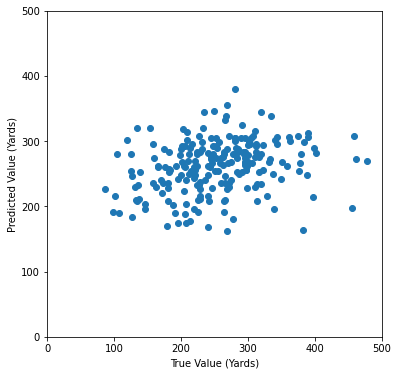

In [24]:
plot_model(lin_reg)

In [31]:
compare_mean_guess(lin_reg)

RMSE model:  73.63035966402306
Mean guesser model:  72.87493160277131


## Random Forest

In [22]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=random_state)
forest_scores = cross_val_score(forest_reg, features_X, labels,
                             scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [68.96003437 77.03256724 78.54995096 71.78992012 70.33505933 69.11812738
 70.16604234 69.08226897 72.06587044 64.30763975]
Mean: 71.14074808919761
Standard deviation: 3.9020698887405247


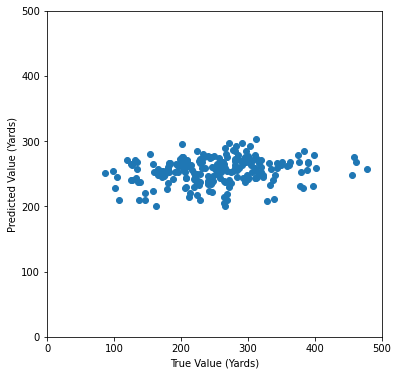

In [25]:
plot_model(forest_reg)

In [32]:
compare_mean_guess(forest_reg)

RMSE model:  71.50984355871473
Mean guesser model:  72.87493160277131
